In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/四下/ML/HW/hw7

Mounted at /content/drive
/content/drive/MyDrive/四下/ML/HW/hw7


In [2]:
import os
import cv2
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist


## Utils

In [3]:
im = Image.open('Yale_Face_Database/Training//subject01.sad.pgm')
im = np.asarray(im, dtype=np.uint8)
h, w = im.shape 

# reduce w, h to half; otherwise the RAM will explode QQ (25G)
(rw, rh) = (100, 100)
img_size = rw * rh

In [4]:
def read_faces(dir):
    files = os.listdir(dir)
    n = len(files)
    faces = np.zeros((n, img_size))
    labels = np.zeros(n, dtype=int)
    for i, fname in enumerate(files):
        im = Image.open(f'{dir}/{fname}')
        # convert to gray scale
        im = im.convert("L")
        # use ANTIALIAS to avoid losing quality in resize step
        im = im.resize((rh, rw), Image.ANTIALIAS)
        labels[i] = int(fname[7:9])
        faces[i] = np.array(im).ravel()
    return faces, labels


def show_faces(faces, row, col, msg):
    plt.figure(msg)
    for i in range(len(faces)):
        plt.subplot(row, col, i + 1)
        plt.axis('off')
        plt.imshow(faces[i], cmap='gray')
    plt.show()


def recognize_faces(train_w, test_w, k=5):
    err = 0.0
    cnt_test = len(test_labels)
    cnt_train = len(train_labels)
    
    dist = np.zeros(cnt_train)
    for i in range(cnt_test):
        for j in range(cnt_train):
            dist[j] = cdist([test_w[i]], [train_w[j]], 'sqeuclidean')
        k_nearst = np.argsort(dist)[:k]
        predict = np.argmax(np.bincount(train_labels[k_nearst]))
        err += 1 if test_labels[i] != predict else 0
    print("Testing Acc = ", (cnt_test - err) / cnt_test)

In [5]:
def getEigen(C, method, loadMode=False, sym=False):
    if(loadMode):
      eig_vals = np.load(f'npy/{method}_eig_vals.npy')
      eig_vecs = np.load(f'npy/{method}_eig_vecs.npy')
      return eig_vals, eig_vecs
    else:
        if(sym):
            eig_vals, eig_vecs = np.linalg.eigh(C)
            np.save(f'npy/{method}_eig_vals.npy', eig_vals)
            np.save(f'npy/{method}_eig_vecs.npy', eig_vecs)
            return eig_vals, eig_vecs
        else:
            eig_vals, eig_vecs = np.linalg.eig(C)
            np.save(f'npy/{method}_eig_vals.npy', eig_vals)
            np.save(f'npy/{method}_eig_vecs.npy', eig_vecs)
            return eig_vals, eig_vecs

In [6]:
train_faces, train_labels = read_faces('Yale_Face_Database/Training/')
test_faces, test_labels = read_faces('Yale_Face_Database/Testing/')

## PCA

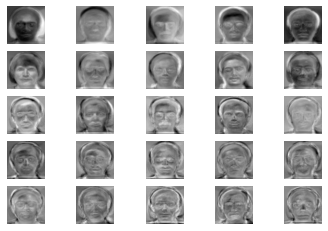

***************************************************************

k = 25


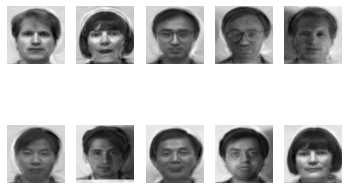

***************************************************************

Testing Acc =  0.9
***************************************************************



In [23]:
def PCA(X, X_test, train_labels, test_labels):
    mu = np.mean(X, axis=0)

    # X_mu.shape = (img_size, num)
    X_mu = (X - mu).T
    C = X_mu @ X_mu.T / len(X)
    eig_vals, eig_vecs = getEigen(C, method="PCA", loadMode=True, sym=True)
    eif_vecs = eig_vecs / np.linalg.norm(eig_vecs, axis=0)

    # Part1 : show the first 25 eigenfaces
    sort_idx = np.argsort(-eig_vals)
    # faces contains eigen vectors [u1, u2, ... u25]
    U = eig_vecs[:, sort_idx[:25]]
    faces = U.T.reshape(25, rh, rw)
    show_faces(faces, 5, 5, "PCA : 25 eigenfaces")
    print('***************************************************************\n')
    

    # Part1 : randomly pick 10 images to show their reconstruction
    idx = np.random.choice(len(X), 10)
    # W : (10,  img_size) @ (img_size, 25)
    for k in [25]:
        print(f'k = {k}')
        # U : select k eigen vectors
        U = eig_vecs[:, sort_idx[:k]]

        # W : project X to U, (10, k)
        W = (X[idx] - mu) @ U

        # reconstruct_faces's = μ + Σwiui
        reconstruct_faces = (mu + W @ U.T).reshape(10, rh, rw)
        show_faces(reconstruct_faces, 2, 5, f'PCA : 10 reconstruction with {k}')
        print('***************************************************************\n')
    
    
    # Part 2 : do face recognition and compute the performance
    U = eig_vecs[:, sort_idx[:25]]
    W_train = (X - mu) @ U
    W_test = (X_test - mu) @ U
    recognize_faces(W_train, W_test)
    print('***************************************************************\n')

    return


if __name__ == '__main__':
    PCA(train_faces, test_faces, train_labels, test_labels)

##LDA

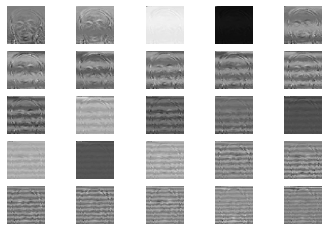

***************************************************************

k = 25


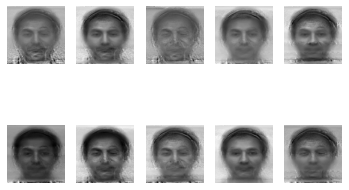

***************************************************************

Testing Acc =  0.8666666666666667
***************************************************************



In [26]:
def LDA(X, X_test, train_labels, test_labels):
    mu = np.mean(X, axis=0)

    numClass = 15
    
    Sb = np.zeros((img_size, img_size))
    Sw = np.zeros((img_size, img_size))
    for i in range(1, numClass+1):
        faces_i = train_faces[train_labels == i]
        mu_i = np.mean(faces_i, axis=0)
        # (xk - μi)
        xk_mui = (faces_i - mu_i).T
        # Sw += Si = (xk - μi)(xk - μi).T
        Sw += xk_mui @ xk_mui.T
        
        # (μi - μ)
        mui_mu = (mu_i - mu).T
        # Sb += Ni(μi - μ)(μi - μ).T
        Sb += len(faces_i) * mui_mu @ mui_mu.T    
    
    S = np.linalg.pinv(Sw) @ (Sb)
    np.save('npy/LDA_S.npy',S)
    # S = np.load('npy/LDA_S.npy')
    
    eig_vals, eig_vecs = getEigen(S, method="LDA", loadMode=False, sym=True)
    eif_vecs = eig_vecs / np.linalg.norm(eig_vecs, axis=0)


    # Part1 : show the first 25 eigenfaces
    sort_idx = np.argsort(-eig_vals)
    # faces contains eigen vectors [u1, u2, ... u25]
    U = (eig_vecs[:, sort_idx[:25]]).real
    faces = (U.T).reshape(25, rh, rw)
    show_faces(faces, 5, 5, "LDA : 25 eigenfaces")
    print('***************************************************************\n')
    

    # Part1 : randomly pick 10 images to show their reconstruction
    idx = np.random.choice(len(X), 10)
    # W : (10,  img_size) @ (img_size, 25)
    for k in [25]:
        print(f'k = {k}')
        # U : select k eigen vectors
        U = eig_vecs[:, sort_idx[:k]].real

        # W : project X to U, (10, k)
        W = (X[idx] - mu) @ U

        # reconstruct_faces's = μ + Σwiui
        reconstruct_faces = (mu + W @ U.T).reshape(10, rh, rw)
        show_faces(reconstruct_faces, 2, 5, f'LDA : 10 reconstruction with {k}')
        print('***************************************************************\n')
        
    
    # Part 2 : do face recognition and compute the performance
    k = 25
    U = eig_vecs[:, sort_idx[:k]].real
    W_train = (X - mu) @ U
    W_test = (X_test - mu) @ U
    recognize_faces(W_train, W_test)
    print('***************************************************************\n')

    return


if __name__ == '__main__':
    LDA(train_faces, test_faces, train_labels, test_labels)

## kernal

In [13]:
def RBF_kernel(xi, xj, gamma=1e-7):
    return np.exp( -gamma * cdist(xi, xj,'sqeuclidean'))

## kernal PCA

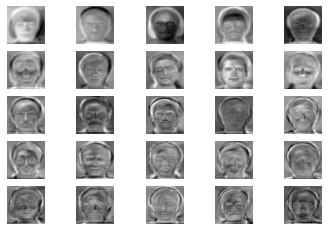

***************************************************************

k = 25


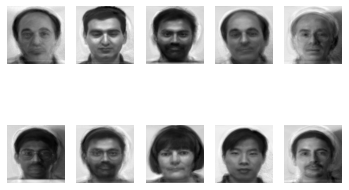

***************************************************************

Testing Acc =  0.8666666666666667
***************************************************************



In [11]:
def kernel_PCA(X, X_test, train_labels, test_labels):

    mu = np.mean(X, axis=0)
    X_mu = (X - mu).T
    K = RBF_kernel(X_mu, X_mu)
    lnn = np.ones((img_size, img_size)) / img_size
    S = K - (lnn @ K) - (K @ lnn) + (lnn @ K @ lnn)
    np.save('npy/kernel_PCA_S.npy', S)
    # S = np.load('npy/kernel_PCA_S.npy')    
    
    eig_vals, eig_vecs = getEigen(S, method="PCA_Kernal", loadMode=True, sym=True)
    eif_vecs = eig_vecs / np.linalg.norm(eig_vecs, axis=0)

    # Part1 : show the first 25 eigenfaces
    sort_idx = np.argsort(-eig_vals)
    # faces contains eigen vectors [u1, u2, ... u25]
    U = eig_vecs[:, sort_idx[:25]]
    faces = U.T.reshape(25, rh, rw)
    show_faces(faces, 5, 5, "kernal PCA : 25 eigenfaces")
    print('***************************************************************\n')

    #. Part1 : randomly pick 10 images to show theit reconstruction
    idx = np.random.choice(len(X), 10)
    # W : (10,  img_size) @ (img_size, 25)
    for k in [25]:
        print(f'k = {k}')
        # U : select k eigen vectors
        U = eig_vecs[:, sort_idx[:k]].real

        # W : project X to U, (10, k)
        W = (X[idx] - mu) @ U

        # reconstruct_faces's = μ + Σwiui
        reconstruct_faces = (mu + W @ U.T).reshape(10, rh, rw)
        show_faces(reconstruct_faces, 2, 5, f'Kernal PCA : 10 reconstruction with {k}')
        print('***************************************************************\n')

    # Part 2 : do face recognition and compute the performance
    k = 25
    U = eig_vecs[:, sort_idx[:k]].real
    W_train = (X - mu) @ U
    W_test = (X_test - mu) @ U
    recognize_faces(W_train, W_test)
    print('***************************************************************\n')
    return


if __name__ == '__main__':
    train_faces, train_labels = read_faces('Yale_Face_Database/Training/')
    test_faces, test_labels = read_faces('Yale_Face_Database/Testing/')
    
    kernel_PCA(train_faces, test_faces, train_labels, test_labels)

## kernal LDA

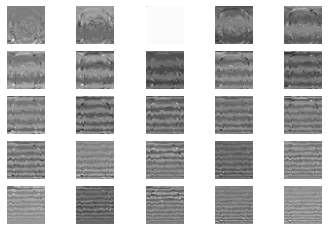

***************************************************************

k = 25


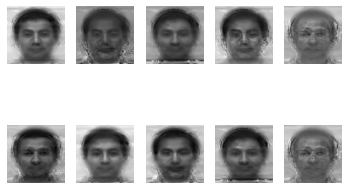

***************************************************************

Testing Acc =  0.8666666666666667
***************************************************************



In [14]:
def kernel_LDA(X, X_test, train_labels, test_labels):
    
    mu = np.mean(X, axis=0)
    K = RBF_kernel(X.T, X.T)
    mu_star = np.sum(K, axis = 0) / len(train_faces)
    
    numClass = 15
    Sb = np.zeros((img_size, img_size))
    Sw = np.zeros((img_size, img_size))
    for i in range(1, numClass+1):
        idx = np.where(train_labels == i)[0]
        Kj = K[idx]
        lj = len(idx)
        mu_i = np.mean(Kj, axis=0)

        # 1_ij : all entries equal to 1/lj
        l_lj = np.full((lj, lj), 1.0 / lj)
        # Sw += Kj (I - 1_lj) Kj.T
        Kj = Kj.T
        Sw += Kj @ (np.eye(lj) - l_lj) @ Kj.T
        
        # (μi - μ*)
        mui_mu = (mu_i - mu_star).T
        # Sb += li(μi - μ*)(μi - μ*).T
        Sb += lj * mui_mu @ mui_mu.T    
    
    S = np.linalg.pinv(Sw) @ (Sb)
    np.save('npy/kernal_LDA_S.npy',S)
    # S = np.load('npy/kernal_LDA_S.npy')
    
    eig_vals, eig_vecs = getEigen(S, method="kernal_LDA", loadMode=False, sym=True)
    eif_vecs = eig_vecs / np.linalg.norm(eig_vecs, axis=0)


    # Part1 : show the first 25 eigenfaces
    sort_idx = np.argsort(-eig_vals)
    # faces contains eigen vectors [u1, u2, ... u25]
    U = (eig_vecs[:, sort_idx[:25]]).real
    faces = (U.T).reshape(25, rh, rw)
    show_faces(faces, 5, 5, "kernal LDA : 25 eigenfaces")
    print('***************************************************************\n')
    

    # Part1 : randomly pick 10 images to show their reconstruction
    idx = np.random.choice(len(X), 10)
    # W : (10,  img_size) @ (img_size, 25)
    for k in [25]:
        print(f'k = {k}')
        # U : select k eigen vectors
        U = eig_vecs[:, sort_idx[:k]].real

        # W : project X to U, (10, k)
        W = (X[idx] - mu) @ U

        # reconstruct_faces's = μ + Σwiui
        reconstruct_faces = (mu + W @ U.T).reshape(10, rh, rw)
        show_faces(reconstruct_faces, 2, 5, f'kernal LDA : 10 reconstruction with {k}')
        print('***************************************************************\n')
        
    
    # Part 2 : do face recognition and compute the performance
    k = 25
    U = eig_vecs[:, sort_idx[:k]].real
    W_train = (X - mu) @ U
    W_test = (X_test - mu) @ U
    recognize_faces(W_train, W_test)
    print('***************************************************************\n')

    return


if __name__ == '__main__':
    kernel_LDA(train_faces, test_faces, train_labels, test_labels)

## t-SNE

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.386597
Iteration 10: error is 23.589033
Iteration 20: error is 21.039987
Iteration 30: error is 18.182107
Iteration 40: error is 16.904159
Iteration 50: error is 16.454944
Iteration 60: error is 16.221031
Iteration 70: error is 16.139551
Iteration 80: error is 16.062743
Iteration 90: error is 15.998314
Iteration 100: error is 15.949766
Iteration 110: error is 2.319181
Iteration 120: error is 2.079127
Iteration 130: error is 1.897169
Iteration 140: error is 1.759117
Iteration 150: error is 1.653254
Iteration 160: error is 1.569998
Iteration 170: error is 1.503294
It

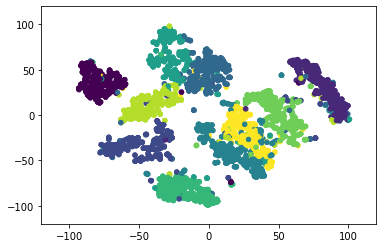

In [ ]:
import numpy as np
import pylab


def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """
    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(ssne=False, X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    images = []
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        if(ssne):
            num = np.exp(-1. * np.add(np.add(num, sum_Y).T, sum_Y))
        else:
            num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            if(ssne):
                dY[i, :] = np.sum(np.tile(PQ[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)
            else:
                dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))
            plotImage(Y, labels, ssne, iter+1)
            

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

def plotImage(Y, labels, ssne, iter):
    pylab.clf()
    fname = ''
    if (ssne):
        fname = f'./output/ssne/{iter}.png'
        bound = [-10, 10]
    else:
        bound = [-120, 120]
        fname = f'./output/tsne/{iter}.png'
    pylab.xlim(bound)
    pylab.ylim(bound)
    pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
    pylab.savefig(fname)


if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    X = np.loadtxt("./tsne_python/mnist2500_X.txt")
    labels = np.loadtxt("./tsne_python/mnist2500_labels.txt")
    Y = tsne(False, X, 2, 50, 20.0)
    pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
    pylab.show()


In [ ]:
from PIL import Image
def gifBuilder(dir):
    gif = []
    for i in range(100):
        gif.append(Image.open(f'output/{dir}/{(i + 1) * 10}.png'))
    gif[0].save(f'output/{dir}.gif',
                format='GIF',
                save_all=True,
                append_images=gif[1:],
                duration=200, loop=0)
    

gifBuilder('tsne')